In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from treeffuser.sde import get_sde

%load_ext autoreload
%autoreload 2

## Goal 
- Fix a generative process for a simulated dataset, 
- then explore the behavior of the different diffusion processes induced by the different SDEs
 

100%|██████████| 3/3 [00:00<00:00, 160.69it/s]


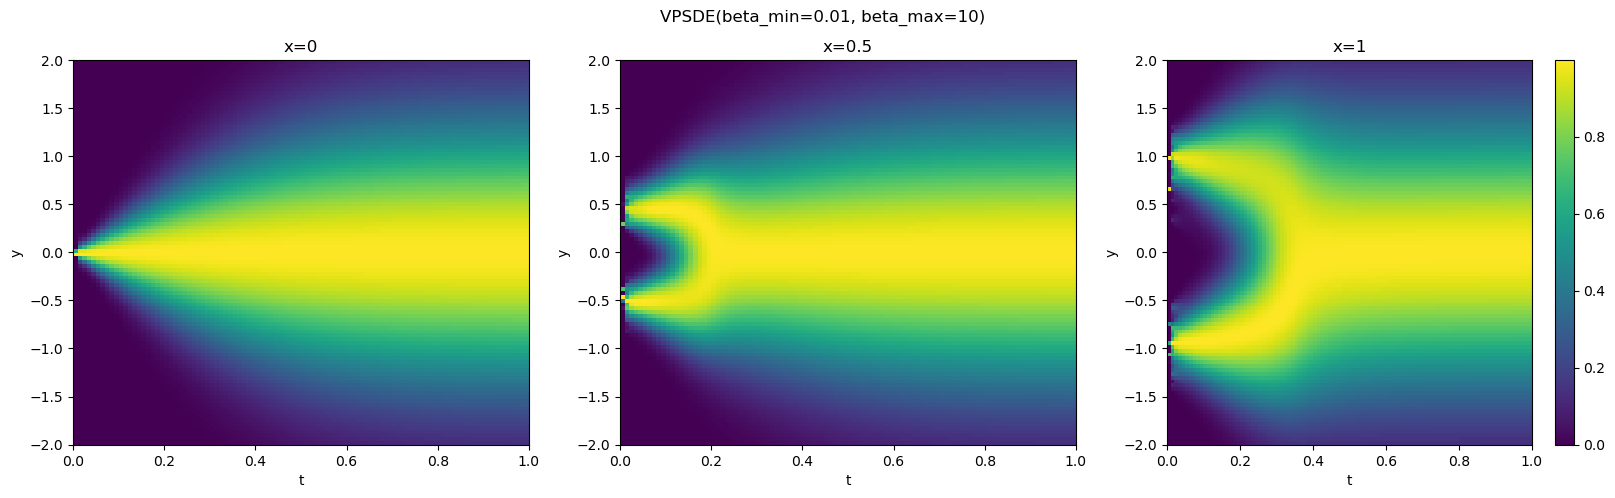

100%|██████████| 3/3 [00:00<00:00, 144.86it/s]


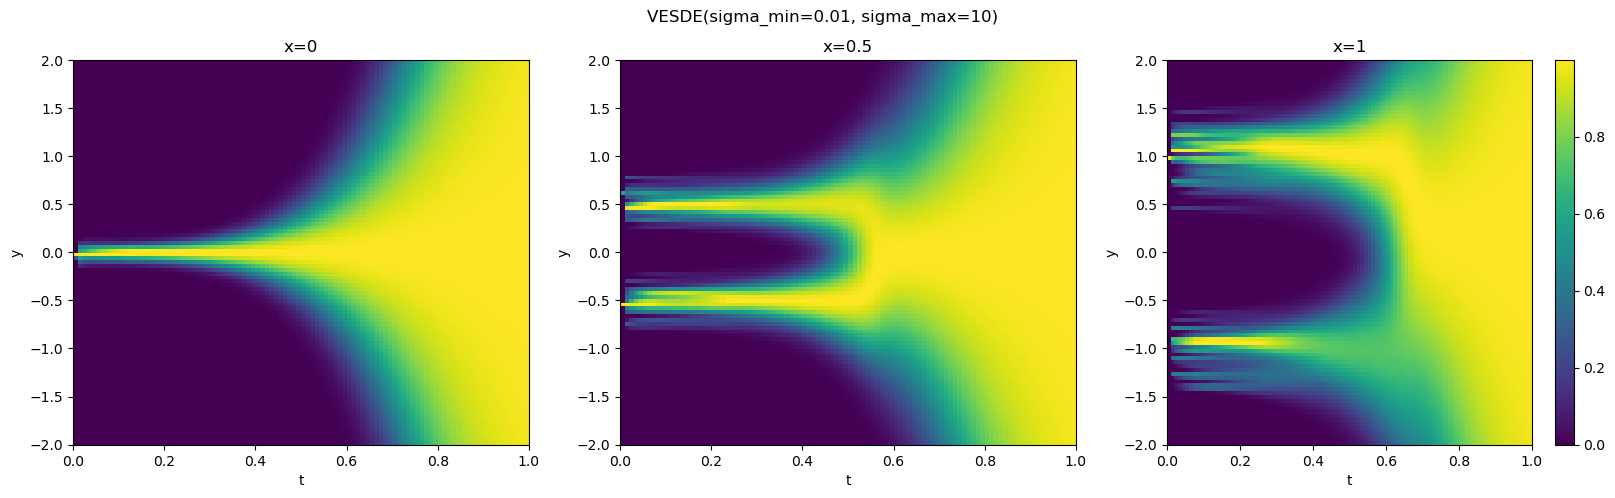

In [2]:
for sde in [get_sde("vpsde")(beta_max=10), get_sde("vesde")(sigma_max=10)]:
    # grid for evaluation
    t_grid = np.linspace(1e-5, 1, 100)
    y_grid = np.linspace(-2, 2, 100)
    y_grid = y_grid[:, None]
    
    xs = [0, 0.5, 1]
    fig, ax = plt.subplots(1, len(xs), figsize=(20, 5))
    
    n_samples_per_x = 100
    
    all_res = []
    for i, x in enumerate(tqdm.tqdm(xs)):
        # the conditional distribution of y given x
        y_samples = np.random.choice([-x,x], n_samples_per_x).astype(np.float64)
        y_samples += np.random.randn(n_samples_per_x) * 0.05 * (x + 1) ** 2
        y_samples = y_samples[:, None]
        
        perturbation_kernel_density = sde.get_marginalized_perturbation_kernel(y_samples)
        res = []
        for t in t_grid:
            res.append(perturbation_kernel_density(y_grid, t))
        res = np.array(res)
        all_res.append(res)   
    
    all_res = np.array(all_res)
    
    # normalize each density to have max 1 for better visualization of the color map
    all_res = all_res / all_res.max(axis=2, keepdims=True)
    # ##############################################################################
    vmin = 0
    vmax = np.quantile(all_res, 0.99) 
    for i, x in enumerate(xs):
        res = all_res[i]
        im = ax[i].imshow(res.T, extent=[0, 1, -2, 2], aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
        ax[i].set_title(f'x={x}')
        ax[i].set_xlabel('t')
        ax[i].set_ylabel('y')
    plt.colorbar(im)
    plt.suptitle(str(sde))
    plt.show()